# [Neuralink Time Series Forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)


## Imports


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from glob import glob
import scipy.io
import IPython
import time

## Configure Tensorflow


In [2]:
# Identify if the GPU is detected
# tf.config.list_physical_devices()

# Identify if the GPU is being used.
# tf.debugging.set_log_device_placement(False)

## Import Data


<Axes: title={'center': 'Raw Neural Signal'}, xlabel='Time [s]'>

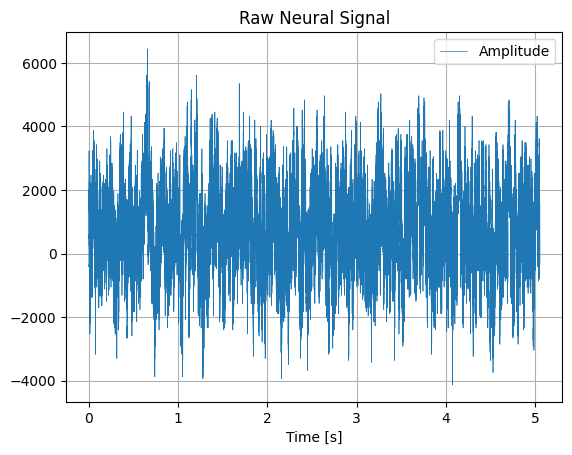

In [3]:
data_dir = "../../data/"
data_file_l = glob(data_dir + "*.wav")
rate, data = scipy.io.wavfile.read(data_file_l[0])
data_df = pd.DataFrame(data, columns=["Amplitude"])
time = np.arange(0, len(data_df) / rate, (1 / rate))
data_df.insert(loc=1, column="Time", value=time, allow_duplicates=True)
data_df.index.name = "Sample Number"
data_df.plot(
    xlabel="Time [s]", x="Time", grid=True, linewidth=0.5, title="Raw Neural Signal"
)

In [4]:
data_df.__len__()

98699

In [5]:
df = data_df.drop("Time", axis=1)

## Defining Training, Validation, & Test Sets


In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = df.__len__()

train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

num_features = df.shape[1]

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_15490/2004759091.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


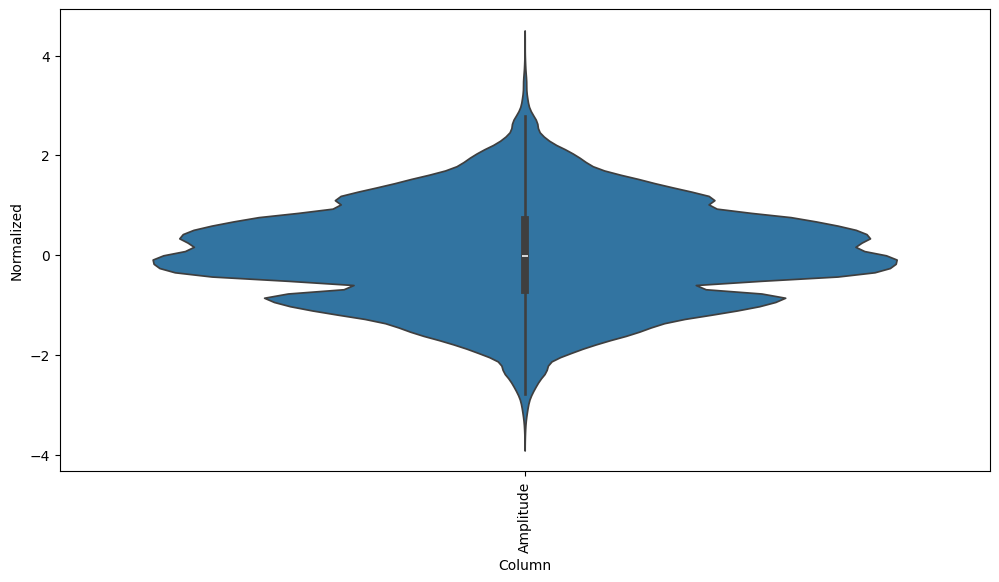

In [8]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [9]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=None,
    ):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

In [10]:
w1 = WindowGenerator(
    input_width=24, label_width=1, shift=24, label_columns=["Amplitude"]
)

In [11]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=["Amplitude"])

In [12]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1,
        )

    # Slicing doesn't preserve static shape information, so set the shapes manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


WindowGenerator.split_window = split_window

In [13]:
# Stack three slices, the length of the total window.
example_window = tf.stack(
    [
        np.array(train_df[: w2.total_window_size]),
        np.array(train_df[100 : 100 + w2.total_window_size]),
        np.array(train_df[200 : 200 + w2.total_window_size]),
    ]
)

example_inputs, example_labels = w2.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


2024-09-06 11:32:37.117954: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-06 11:32:37.117972: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-06 11:32:37.117978: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-06 11:32:37.117992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-06 11:32:37.118002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
w2.example = example_inputs, example_labels

In [15]:
def plot(self, model=None, plot_col="Amplitude", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f"{plot_col} [normed]")
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label="Inputs",
            marker=".",
            zorder=-10,
        )

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(
            self.label_indices,
            labels[n, :, label_col_index],
            edgecolors="k",
            label="Labels",
            c="#2ca02c",
            s=64,
        )
        if model is not None:
            predictions = model(inputs)
            plt.scatter(
                self.label_indices,
                predictions[n, :, label_col_index],
                marker="X",
                edgecolors="k",
                label="Predictions",
                c="#ff7f0e",
                s=64,
            )

        if n == 0:
            plt.legend()

    plt.xlabel("Time [h]")


WindowGenerator.plot = plot

In [16]:
w2.label_columns_indices

{'Amplitude': 0}

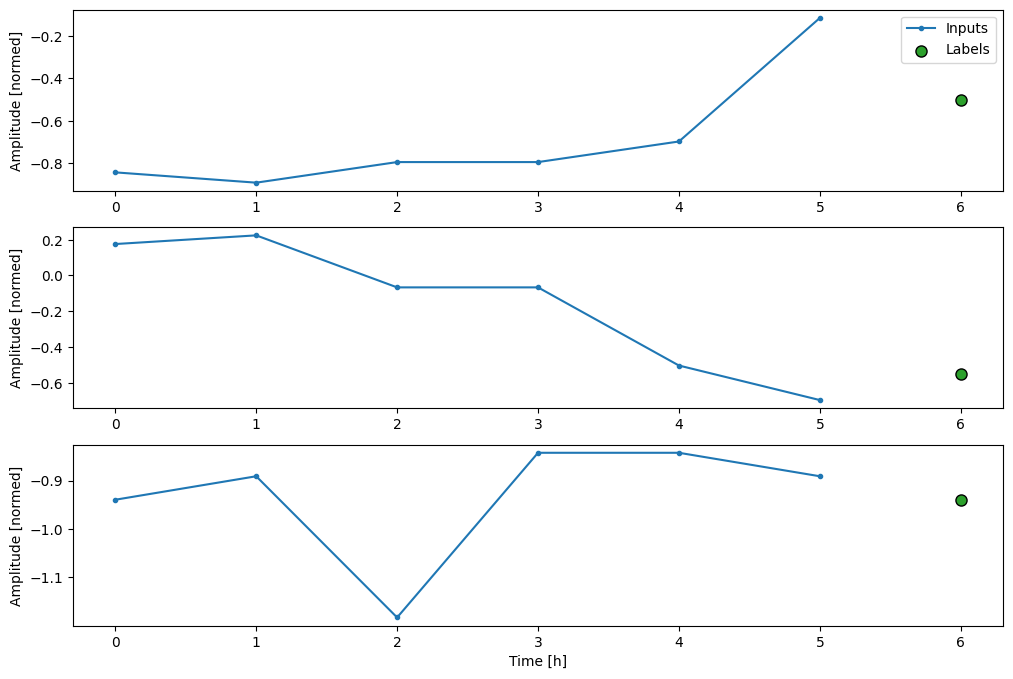

In [17]:
w2.plot()

In [18]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,
    )
    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset

In [19]:
@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """get and cache an example batch of `inputs, labels` for ploting."""
    result = getattr(self, "_example", None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [20]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [21]:
for example_inputs, example_labels in w2.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


2024-09-06 11:32:37.741898: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Single Step Model


In [22]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=["Amplitude"]
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Amplitude']

In [23]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


2024-09-06 11:32:37.862835: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Baseline


In [24]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [25]:
baseline = Baseline(label_index=column_indices["Amplitude"])

baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(
    single_step_window.val, return_dict=True
)
performance["Baseline"] = baseline.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

  1/617 ━━━━━━━━━━━━━━━━━━━━ 1:20 130ms/step - loss: 0.0863 - mean_absolute_error: 0.2337

2024-09-06 11:32:37.947268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.2365


In [26]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=["Amplitude"]
)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Amplitude']

In [27]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


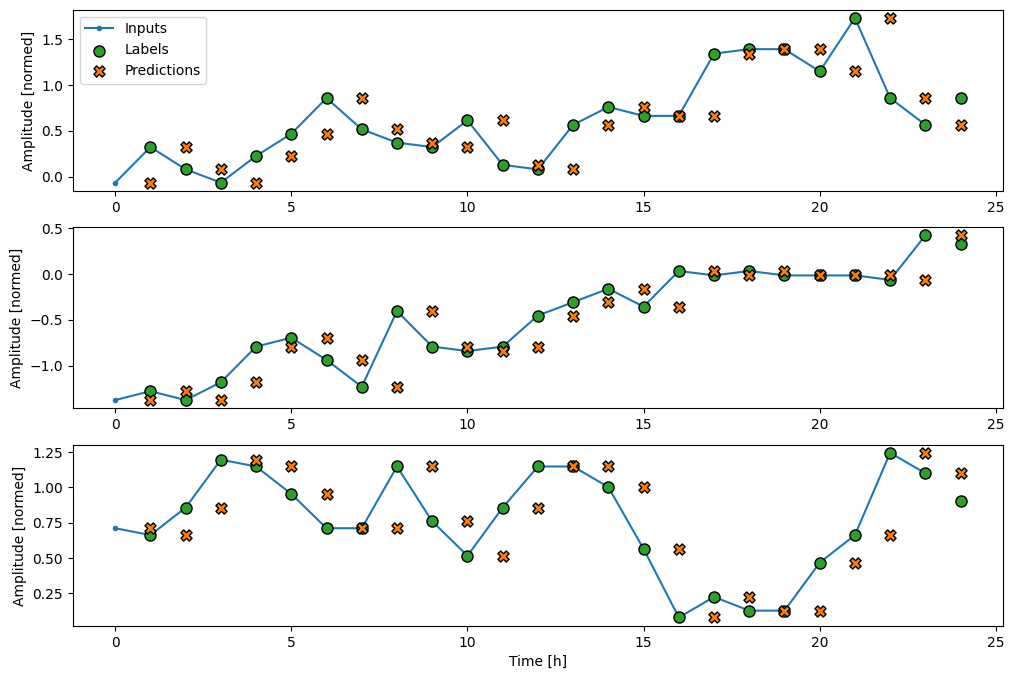

In [28]:
wide_window.plot(baseline)

### Linear Model


In [29]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [30]:
print("Input shape:", single_step_window.example[0].shape)
print("Output shape:", linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


In [31]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history

In [32]:
history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val, return_dict=True)
performance["Linear"] = linear.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

Epoch 1/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.3127 - mean_absolute_error: 0.4216 - val_loss: 0.0866 - val_mean_absolute_error: 0.2337
Epoch 2/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0872 - mean_absolute_error: 0.2337 - val_loss: 0.0866 - val_mean_absolute_error: 0.2338
Epoch 3/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0873 - mean_absolute_error: 0.2339 - val_loss: 0.0866 - val_mean_absolute_error: 0.2338
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0856 - mean_absolute_error: 0.2327


In [33]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", wide_window.example[0].shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


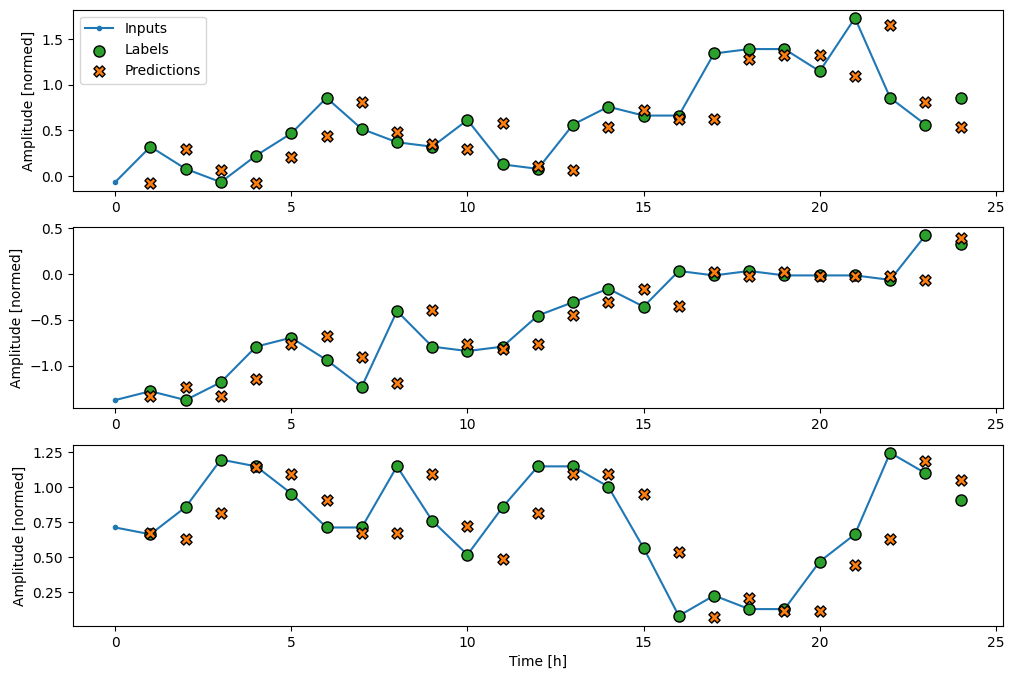

In [34]:
wide_window.plot(linear)

In [35]:
linear.layers[0].kernel[:, 0].numpy()

array([0.96001416], dtype=float32)

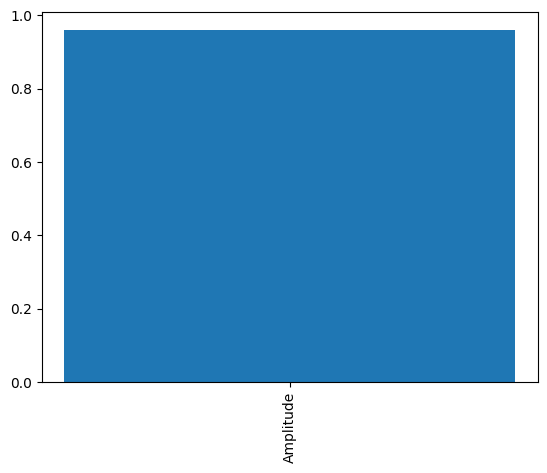

In [36]:
# Visualizing the model's weights assigned to each input

plt.bar(x=range(len(train_df.columns)), height=linear.layers[0].kernel[:, 0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Dense


In [37]:
dense = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

history = compile_and_fit(dense, single_step_window)

val_performance["Dense"] = dense.evaluate(single_step_window.val, return_dict=True)
performance["Dense"] = dense.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

Epoch 1/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.1151 - mean_absolute_error: 0.2559 - val_loss: 0.0872 - val_mean_absolute_error: 0.2346
Epoch 2/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0884 - mean_absolute_error: 0.2359 - val_loss: 0.0865 - val_mean_absolute_error: 0.2342
Epoch 3/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0883 - mean_absolute_error: 0.2357 - val_loss: 0.0869 - val_mean_absolute_error: 0.2345
Epoch 4/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0883 - mean_absolute_error: 0.2359 - val_loss: 0.0865 - val_mean_absolute_error: 0.2343
Epoch 5/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0883 - mean_absolute_error: 0.2360 - val_loss: 0.0872 - val_mean_absolute_error: 0.2350
Epoch 6/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0883 - mean_absolute_error: 0.2359 - val_loss: 0.0868 - val_mean_absolute_error: 0.2345
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0871 - mean_absolute_error: 0.2

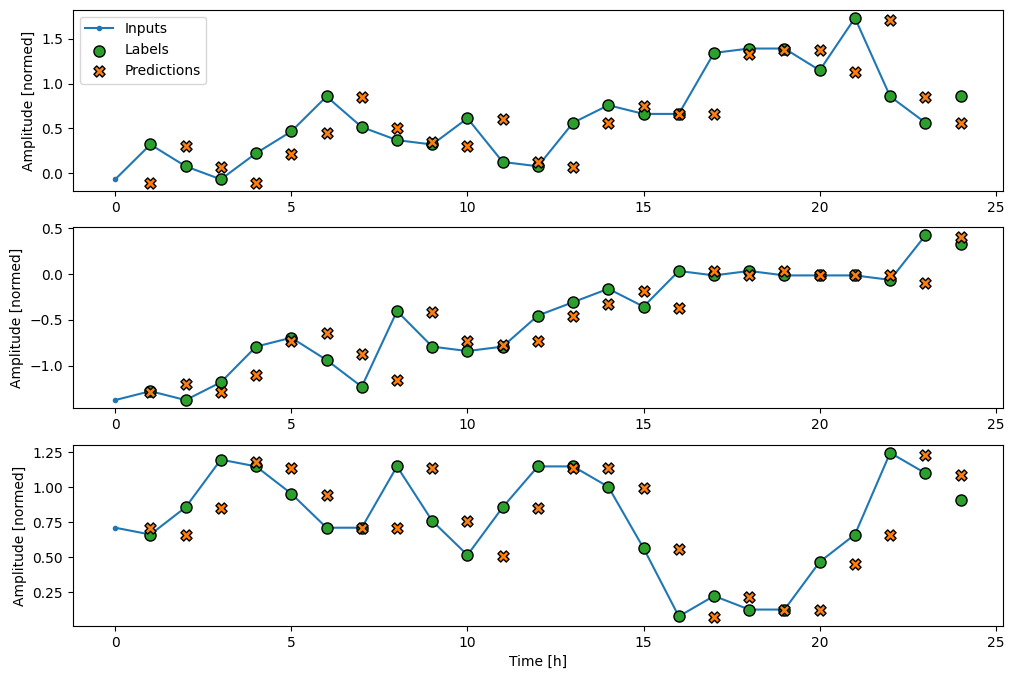

In [38]:
wide_window.plot(dense)

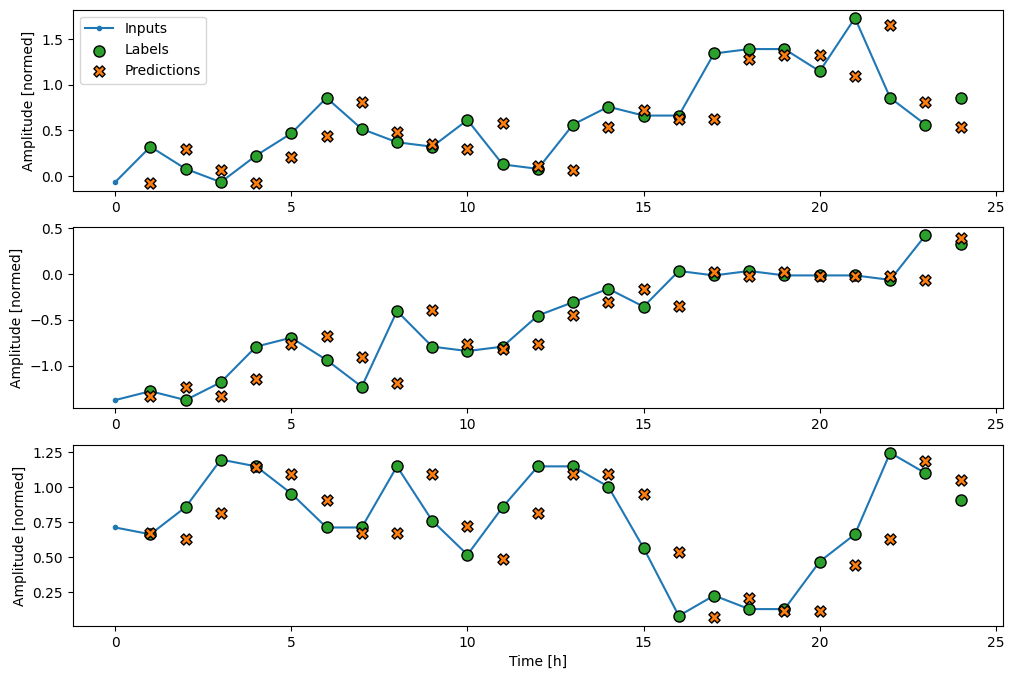

In [39]:
wide_window.plot(linear)

### Multi-step dense


In [40]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH, label_width=1, shift=1, label_columns=["Amplitude"]
)
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Amplitude']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

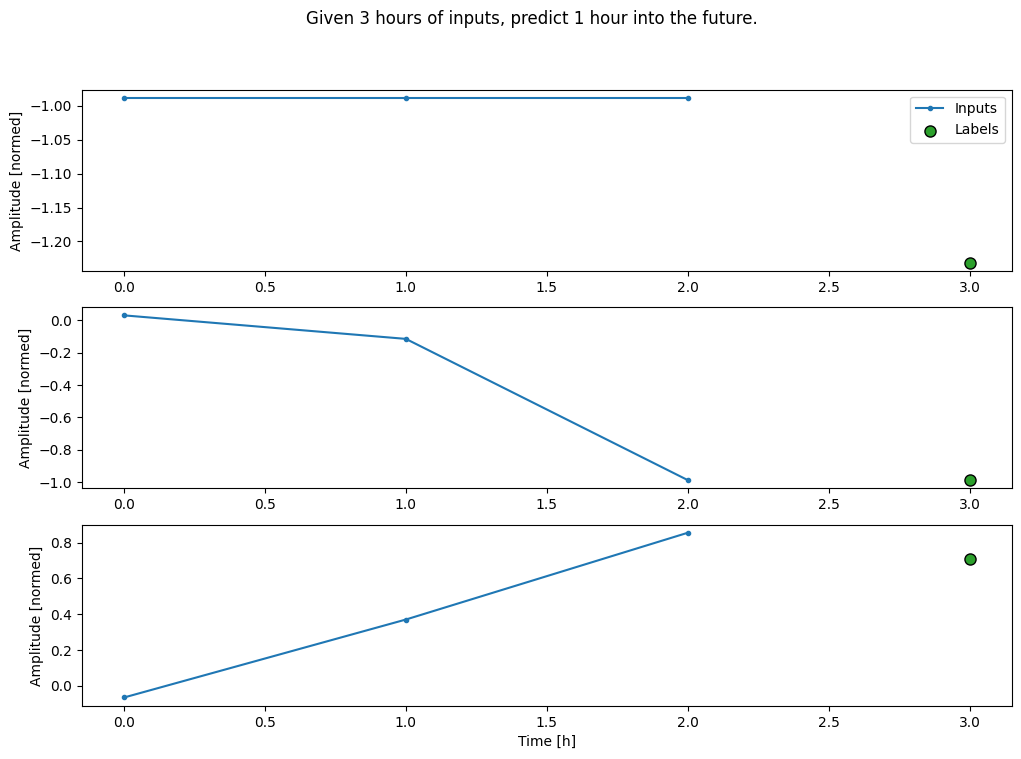

In [41]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [42]:
multi_step_dense = tf.keras.Sequential(
    [
        # Shape: (time, features) => (time*features)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
        # Add back the time dimension.
        # Shape: (outputs) => (1, outputs)
        tf.keras.layers.Reshape([1, -1]),
    ]
)

In [43]:
print("Input shape:", conv_window.example[0].shape)
print("Output shape:", multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [44]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance["Multi step dense"] = multi_step_dense.evaluate(
    conv_window.val, return_dict=True
)
performance["Multi step dense"] = multi_step_dense.evaluate(
    conv_window.test, verbose=0, return_dict=True
)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0849 - mean_absolute_error: 0.2319


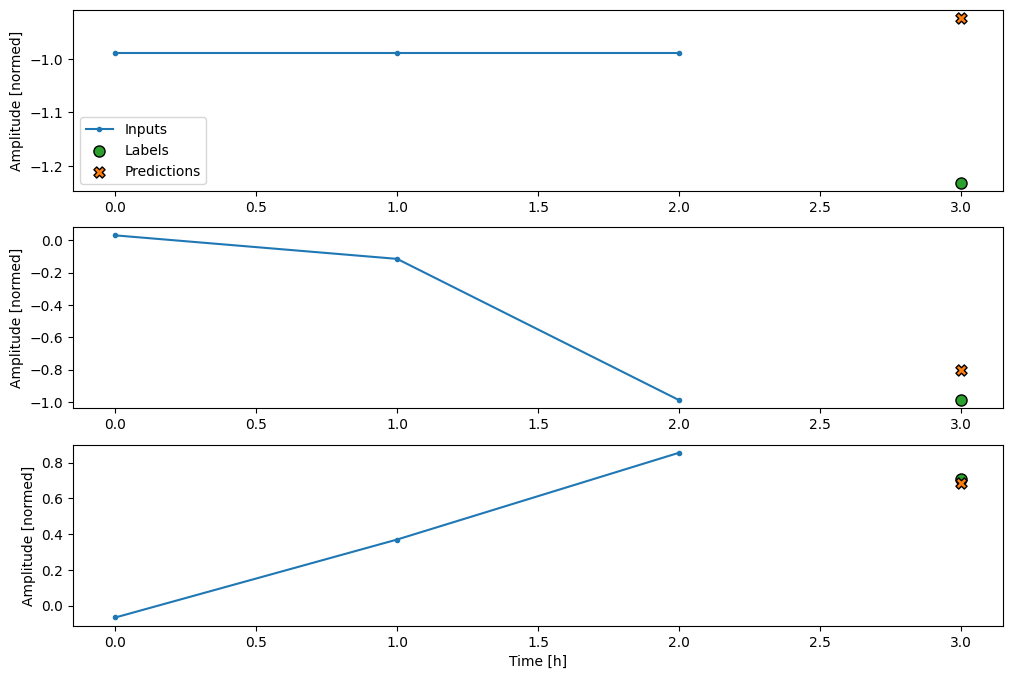

In [45]:
conv_window.plot(multi_step_dense)

In [46]:
# This method is only compatible with inputs of a specific shape.

print("Input shape:", wide_window.example[0].shape)
try:
    print("Output shape:", multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f"\n{type(e).__name__}:{e}")

Input shape: (32, 24, 1)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (32, 24)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 1), dtype=float32)
  • training=None
  • mask=None


### Convolutional Neural Network


In [47]:
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=(CONV_WIDTH,), activation="relu"
        ),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

In [48]:
print("Conv model on `conv_window`")
print("Input shape:", conv_window.example[0].shape)
print("Output shape:", conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [49]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance["Conv"] = conv_model.evaluate(conv_window.val, return_dict=True)
performance["Conv"] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0863 - mean_absolute_error: 0.2344


In [50]:
print("Wide window")
print("Input shape:", wide_window.example[0].shape)
print("Labels shape:", wide_window.example[1].shape)
print("Output shape:", conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [51]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=["Amplitude"],
)

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Amplitude']

In [52]:
print("Wide conv window")
print("Input shape:", wide_conv_window.example[0].shape)
print("Labels shape:", wide_conv_window.example[1].shape)
print("Output shape:", conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


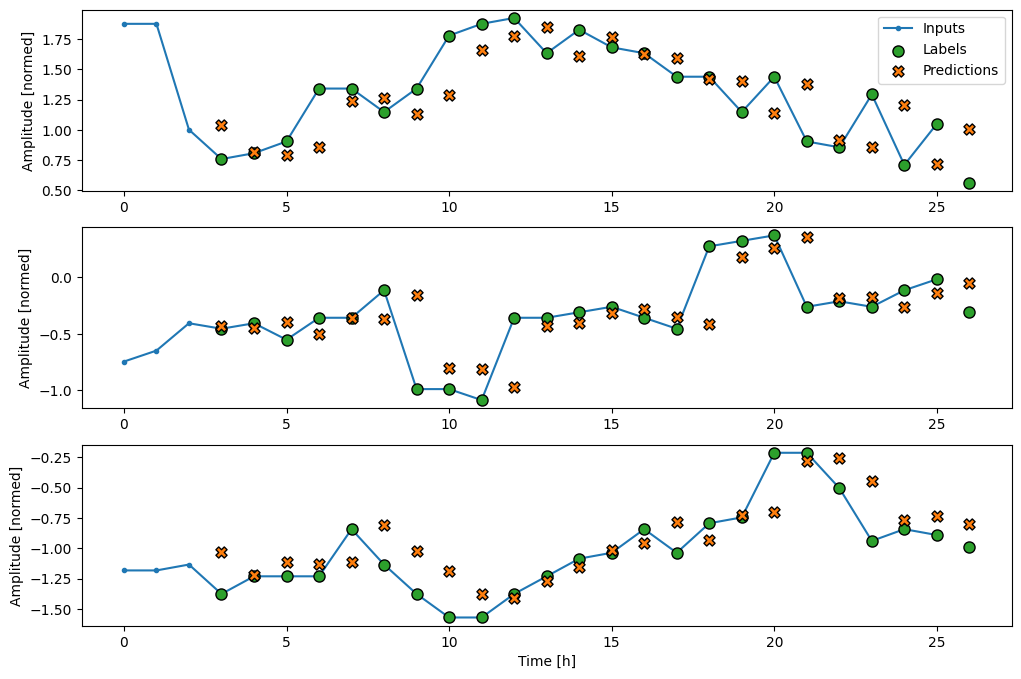

In [53]:
wide_conv_window.plot(conv_model)

### Recurrent Neural Network


In [54]:
lstm_model = tf.keras.models.Sequential(
    [
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1),
    ]
)

In [55]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [56]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance["LSTM"] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance["LSTM"] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0839 - mean_absolute_error: 0.2305


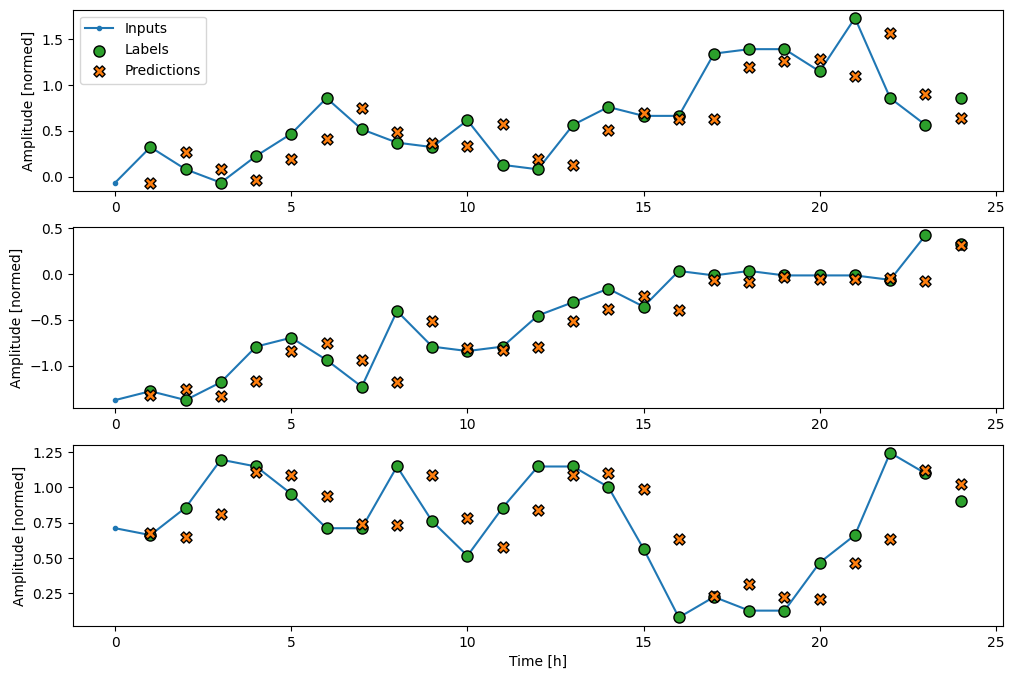

In [57]:
wide_window.plot(lstm_model)

### Performance


In [58]:
cm = lstm_model.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>]

In [59]:
val_performance

{'Baseline': {'loss': 0.08846593648195267,
  'mean_absolute_error': 0.2353304922580719},
 'Linear': {'loss': 0.08662983030080795,
  'mean_absolute_error': 0.23378737270832062},
 'Dense': {'loss': 0.08679001778364182,
  'mean_absolute_error': 0.23451568186283112},
 'Multi step dense': {'loss': 0.08545254170894623,
  'mean_absolute_error': 0.23273596167564392},
 'Conv': {'loss': 0.08587333559989929,
  'mean_absolute_error': 0.2334175407886505},
 'LSTM': {'loss': 0.0838327631354332,
  'mean_absolute_error': 0.2301938682794571}}

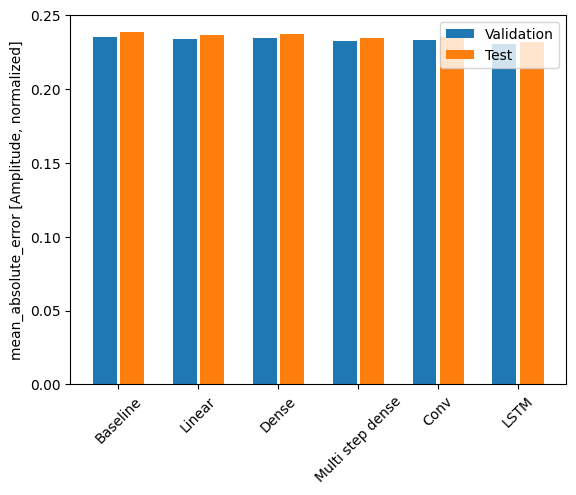

In [60]:
x = np.arange(len(performance))
width = 0.3
metric_name = "mean_absolute_error"
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel("mean_absolute_error [Amplitude, normalized]")
plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

In [61]:
for name, value in performance.items():
    print(f"{name:12s}: {value[metric_name]:0.4f}")

Baseline    : 0.2383
Linear      : 0.2364
Dense       : 0.2375
Multi step dense: 0.2347
Conv        : 0.2350
LSTM        : 0.2321


### Multi-output models


In [62]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1,
    label_width=1,
    shift=1,
)

wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 24, 1)
Labels shape (batch, time, features): (32, 24, 1)


#### Baseline


In [63]:
baseline = Baseline()
baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [64]:
val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(wide_window.val, return_dict=True)
performance["Baseline"] = baseline.evaluate(
    wide_window.test, verbose=0, return_dict=True
)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0887 - mean_absolute_error: 0.2356


#### Dense


In [65]:
dense = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=num_features),
    ]
)

#### RNN


In [66]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1
)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

print()

617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0864 - mean_absolute_error: 0.2335

CPU times: user 1min 53s, sys: 1min 1s, total: 2min 55s
Wall time: 1min 12s


#### Advanced Residual Connections


In [67]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each time step is the input
        # from the previous time step plut the delta
        # calculated by the model.
        return inputs + delta

In [68]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(
            num_features, 
            # The predicted deltas should start small.
            # Therefore, initialize the output layer with zeros.
            kernel_initializer=tf.initializers.zeros()
        )
    ]
    )
)

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0838 - mean_absolute_error: 0.2301

CPU times: user 2min 20s, sys: 59.6 s, total: 3min 20s
Wall time: 1min 45s


#### Performance


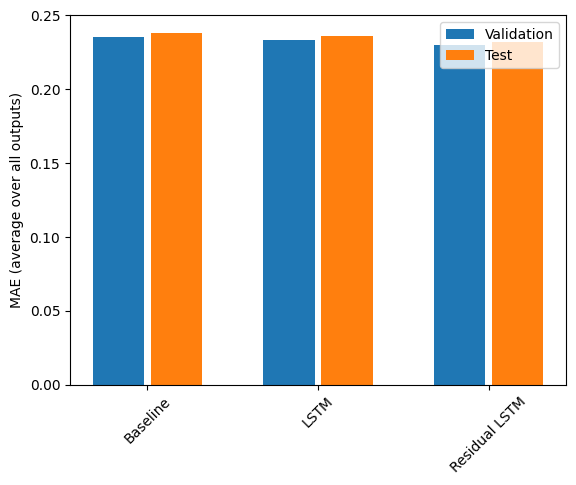

In [69]:
x = np.arange(len(performance))
width = 0.3

metric_name = "mean_absolute_error"
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel("MAE (average over all outputs)")
_ = plt.legend()

In [70]:
for name, value in performance.items():
    print(f"{name:15s}: {value[metric_name]:0.4f}")

Baseline       : 0.2383
LSTM           : 0.2361
Residual LSTM  : 0.2322


### Multi-step models


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

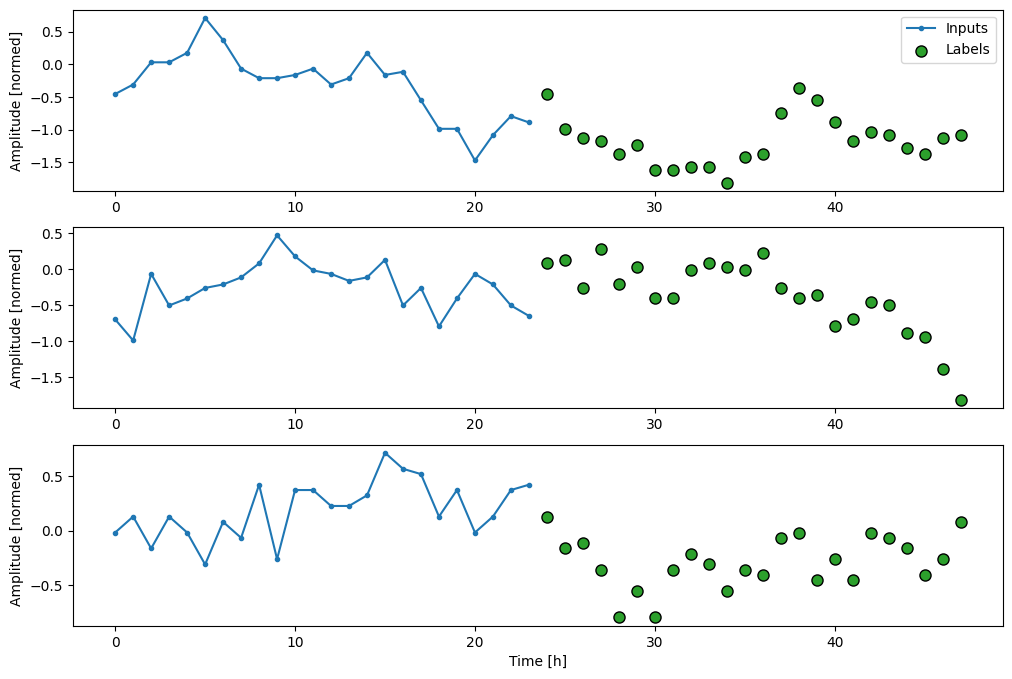

In [71]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_window.plot()
multi_window

In [72]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        tile = tf.tile(inputs[:, -1, :], [1, OUT_STEPS, 1])
        return tile

In [73]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [74]:
multi_val_performance = {}
multi_performance = {}

In [75]:
multi_window.val

<_MapDataset element_spec=(TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>

In [76]:
# multi_val_performance["Last"] = last_baseline.evaluate(
#     multi_window.val, return_dict=True
# )
# multi_performance["Last"] = last_baseline.evaluate(
#     multi_window.test, verbose=0, return_dict=True
# )

### Repeat Baseline


In [77]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs


repeat_baseline = RepeatBaseline()
repeat_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5948 - mean_absolute_error: 0.6154


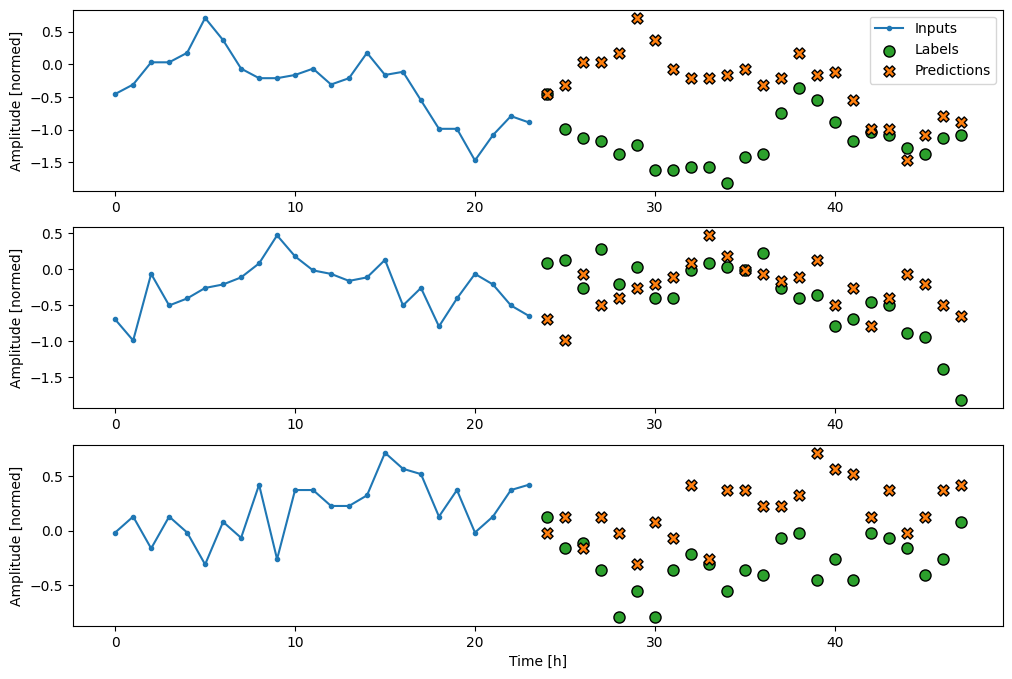

In [78]:
multi_val_performance["Repeat"] = repeat_baseline.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Repeat"] = repeat_baseline.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(repeat_baseline)

### Single-shot models


616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3621 - mean_absolute_error: 0.4720


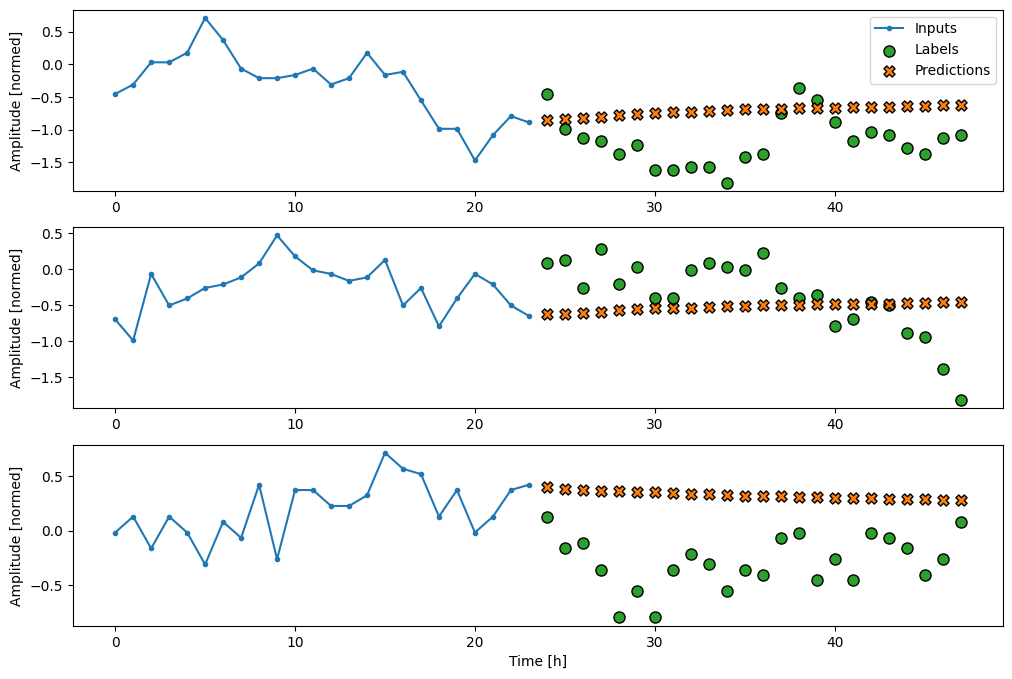

In [79]:
multi_linear_model = tf.keras.Sequential(
    [
        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance["Linear"] = multi_linear_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Linear"] = multi_linear_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_linear_model)

### Dense Multi-Output Model


In [80]:
multi_dense_model = tf.keras.Sequential(
    [
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(512, activation="relu"),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/20
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.3983 - mean_absolute_error: 0.4928 - val_loss: 0.3632 - val_mean_absolute_error: 0.4732
Epoch 2/20
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.3739 - mean_absolute_error: 0.4792 - val_loss: 0.3635 - val_mean_absolute_error: 0.4736
Epoch 3/20
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.3735 - mean_absolute_error: 0.4789 - val_loss: 0.3638 - val_mean_absolute_error: 0.4736


616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3639 - mean_absolute_error: 0.4731


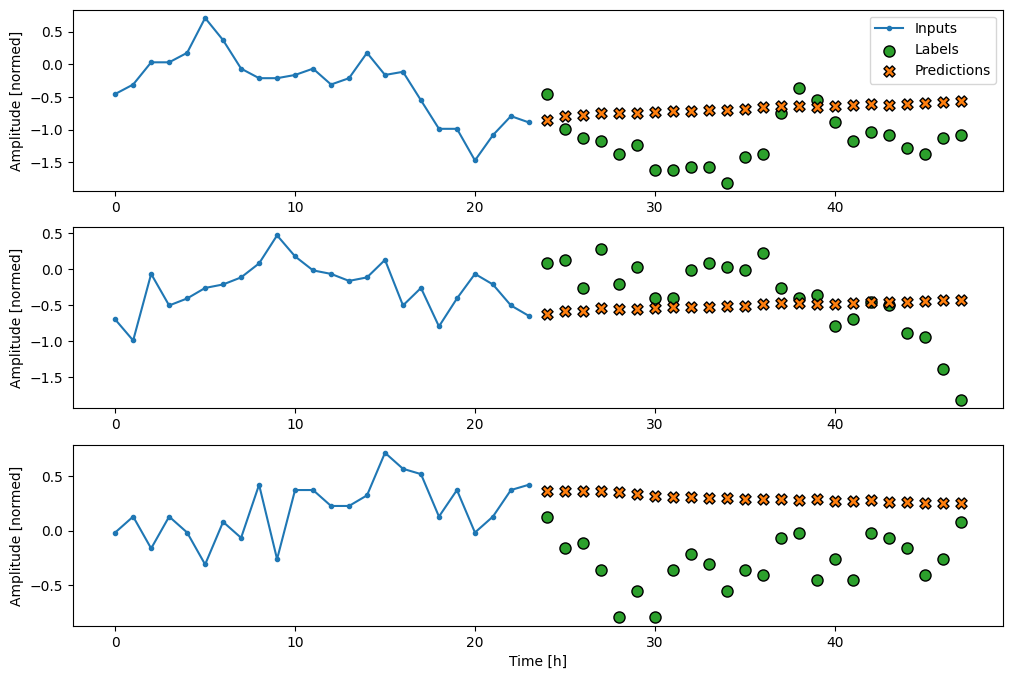

In [81]:
IPython.display.clear_output()
multi_val_performance["Dense"] = multi_dense_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Dense"] = multi_dense_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_dense_model)

#### CNN


616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3506 - mean_absolute_error: 0.4640


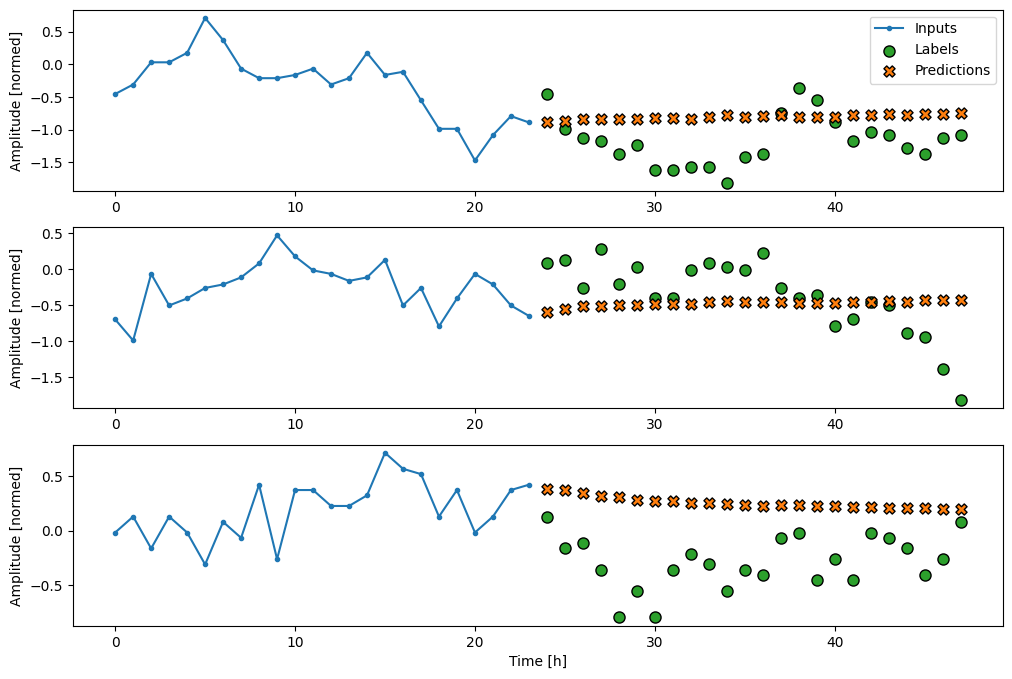

In [82]:
import IPython.display


CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential(
    [
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH)),
        # Shape => [batch, 1, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance["Conv"] = multi_conv_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Conv"] = multi_conv_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_conv_model)

616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3370 - mean_absolute_error: 0.4574


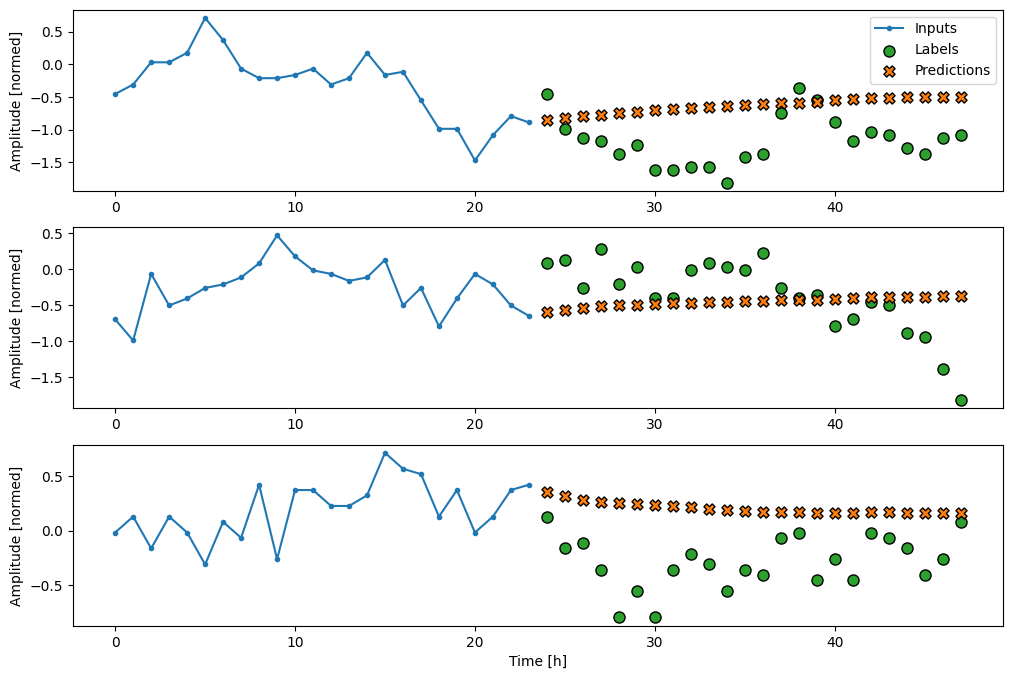

In [83]:
multi_lstm_model = tf.keras.Sequential(
    [
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more`lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance["LSTM"] = multi_lstm_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["LSTM"] = multi_lstm_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_lstm_model)

### Autoregressive model


#### RNN


In [84]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in a RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [86]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state


FeedBack.warmup = warmup

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [88]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state, training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


FeedBack.call = call

In [89]:
print(
    "Output shape (batch, time, features): ",
    feedback_model(multi_window.example[0]).shape,
)

Output shape (batch, time, features):  (32, 24, 1)


In [90]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/20


2024-09-06 11:49:48.816106: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INTERNAL: stream cannot wait for itself
	 [[{{node StatefulPartitionedCall/feed_back_1/rnn_1/while/body/_27/feed_back_1/rnn_1/while/gradient_tape/feed_back_1/rnn_1/while/gradients/feed_back_1/rnn_1/while/lstm_cell_1/add_grad/Shape/_80}}]]
2024-09-06 11:49:48.816432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4068473765970674177
2024-09-06 11:49:48.816440: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8907271634123883767
2024-09-06 11:49:48.816449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6969647932508734659
2024-09-06 11:49:48.816454: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15933478478426310423
2024-09-06 11:49:48.816516: I tensorflow/

InternalError: Graph execution error:

Detected at node StatefulPartitionedCall/feed_back_1/rnn_1/while/body/_27/feed_back_1/rnn_1/while/gradient_tape/feed_back_1/rnn_1/while/gradients/feed_back_1/rnn_1/while/lstm_cell_1/add_grad/Shape/_80 defined at (most recent call last):
<stack traces unavailable>
Detected at node StatefulPartitionedCall/feed_back_1/rnn_1/while/body/_27/feed_back_1/rnn_1/while/gradient_tape/feed_back_1/rnn_1/while/gradients/feed_back_1/rnn_1/while/lstm_cell_1/add_grad/Shape/_80 defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INTERNAL:  stream cannot wait for itself
	 [[{{node StatefulPartitionedCall/feed_back_1/rnn_1/while/body/_27/feed_back_1/rnn_1/while/gradient_tape/feed_back_1/rnn_1/while/gradients/feed_back_1/rnn_1/while/lstm_cell_1/add_grad/Shape/_80}}]]
	 [[Func/StatefulPartitionedCall/gradient_tape/feed_back_1/rnn_1/while/feed_back_1/rnn_1/while_grad/body/_145/input/_380/_286]]
  (1) INTERNAL:  stream cannot wait for itself
	 [[{{node StatefulPartitionedCall/feed_back_1/rnn_1/while/body/_27/feed_back_1/rnn_1/while/gradient_tape/feed_back_1/rnn_1/while/gradients/feed_back_1/rnn_1/while/lstm_cell_1/add_grad/Shape/_80}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_601715]

In [ ]:
IPython.display.clear_output()

multi_val_performance["AR LSTM"] = feedback_model.evaluate(
    multi_window.val, return_dict=True
)

In [ ]:
multi_performance["AR LSTM"] = feedback_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(feedback_model)

#### Performance of the AutoRegressive Model


In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = "mean_absolute_error"
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f"MAE (average over all times and outputs)")
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
    print(f"{name:8s}: {value[metric_name]:0.4f}")

## GRU


### Example GRU


In [ ]:
datapath = os.getcwd() + "/data/AMZN_2006-01-01_to_2018-01-01.csv"

In [ ]:
datapath

In [ ]:
data = pd.read_csv(datapath)
data = data.sort_values("Date")
data.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(15, 9))
plt.plot(data[["Close"]])
plt.xticks(range(0, data.shape[0], 500), data["Date"].loc[::500], rotation=45)
plt.title("Amazon Stock Price", fontsize=18, fontweight="bold")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price (USD)", fontsize=18)
plt.show()

##### Normalizing data


In [ ]:
price = data[["Close"]]
price.info()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price["Close"] = scaler.fit_transform(price["Close"].values.reshape(-1, 1))

In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index : index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

In [ ]:
import torch
import torch.nn as nn

In [ ]:
lookback = 20  # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)

In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = GRU(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
)
criterion = torch.nn.MSELoss(reduction="mean")
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

In [ ]:
import seaborn as sns

sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x=original.index, y=original[0], label="data", color="royalblue")
ax = sns.lineplot(
    x=predict.index, y=predict[0], label="Training Prediction (GRU)", color="tomato"
)
ax.set_title("Stock price", size=14, fontweight="bold")
ax.set_xlabel("Days", size=14)
ax.set_ylabel("Cost (USD", size=14)
ax.set_xticklabels("", size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color="royalblue")
ax.set_xlabel("Epoch", size=14)
ax.set_ylabel("Loss", size=14)
ax.set_title("Training Loss", size=14, fontweight="bold")
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
print("Test Score: %.2f RMSE" % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback : len(y_train_pred) + lookback, :] = y_train_pred

# shift test prediction for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred) + lookback - 1 : len(price) - 1, :] = y_test_pred

original = scaler.inverse_transform(price["Close"].values.reshape(-1, 1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
plt.title("GRU Results")
plt.plot(result.index, result[0], label="train")
plt.plot(result.index, result[1], label="test")
plt.plot(result.index, result[2], label="original", linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
plt.plot(result[1])

In [ ]:
sub_original_values = result[2][result[1] > 0]

In [ ]:
sub_original_values["Test"] = result[1]

In [ ]:
sub_test_values = result[1][result[1] > 0]

In [ ]:
sub_original_value

In [ ]:
sub_test_values

In [ ]:
sub_df = pd.concat([sub_original_values, sub_test_values], axis=1)
sub_df.columns = ["Original", "Test"]

In [ ]:
sub_df["Residuals"] = sub_df["Original"] - sub_df["Test"]

In [ ]:
sub_df.loc[(sub_df["Residuals"] < 1) & (sub_df["Residuals"] > -1)]

In [ ]:
plt.title("Test Values Vs. Original Values")
plt.plot(
    result[2][result[1] > 0].index, result[2][result[1] > 0], label="Original values"
)
plt.plot(result[1], label="Test Values")
plt.plot(sub_df["Residuals"], label="Residuals")
plt.axhline(y=0)
plt.legend()
plt.show()

#### Importing Data & Creating Training DataFrame of Neural Data


##### Importing Data


In [ ]:
data_dir = "../../data/"
data_file_l = glob(data_dir + "*.wav")
rate, data = scipy.io.wavfile.read(data_file_l[0])
data_df = pd.DataFrame(data, columns=["Amplitude"])
data_df.index.name = "Sample"

In [ ]:
# time = np.arange(0, len(data_df) / rate, (1 / rate))
# data_df.insert(loc=1, column="Time", value=time, allow_duplicates=True)

In [ ]:
df = data_df

##### Creating Training Data Frames


In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = df.__len__()

train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

#### Applying Neural Data to GRU model


##### Function Definitions


In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index : index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

##### Splitting the Data into Training and Test Sets


In [ ]:
lookback = 20  # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

##### Defining the Neural Network


In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = GRU(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
)
criterion = torch.nn.MSELoss(reduction="mean")
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

##### Training the Neural Network


In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

##### Reformatting the Data


In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))